# Identifying duplications

In [3]:
import json
import os
import pandas as pd

from plotly.offline import init_notebook_mode
from sqlalchemy import create_engine

from query_flow.parsers.postgres_parser import PostgresParser
from query_flow.vizualizers.query_vizualizer import QueryVizualizer

# The following lines only needed for rendering in github
# and require conda install -c plotly plotly-orca psutil
import plotly.io as pio
pio.renderers.default = "png"

**Problems related to duplicate entries are common and finding them is extremely hard.** By using QueryFlow to visualize the cardinality of sub-expressions of our query, we can find duplications. This problem can be caused due to either JOIN, UNION ALL, etc. 

To show an example of identifying duplications, we introduce the following question in TPCH, “find all movies with genres that are safe for kids from the last two years”. This question is equivalent to the SQL query in next cell, but to make it work without generating the database locally we will use a mock of the execution plan.

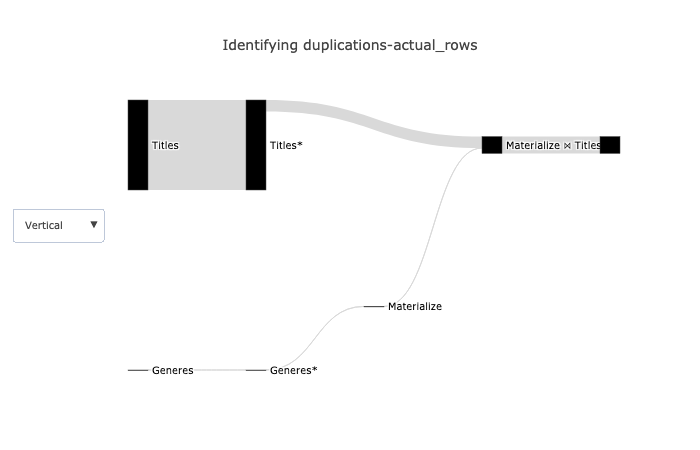

In [4]:
con_str = 'postgresql:///etrabelsi_thesis'
parser = PostgresParser()
query_renderer = QueryVizualizer(parser)
query = """
        SELECT *
        FROM titles
        INNER JOIN generes
                ON position(generes.genere_name in titles.genres) > 0
        WHERE titles.premiered >= date_part('year', CURRENT_DATE) - 2 AND
              generes.kid_safe = True"""
if os.environ.get("NOT_MOCK"):
    flow_df = query_renderer.get_flow_df(query, con_str)    
else:
    mock_path = f'../tests/parsers/data/postgres/parse/identify_duplications/execution_plan.json'
    flow_df = parser.parse([json.loads(open(mock_path).read())])

query_renderer.vizualize(flow_df, title="Identifying duplications", metrics=["actual_rows"], open_=False)

**Using the Sankey visualization, we can see that the Join sub-expression is exploding (it is bigger than its direct ancestor and we expected one-to-one relationship)**. The explosion occurs when a title has multiple genres (Comedy, Action) and we want to join the genres relation (each row represents only one genres). This allows us to understand if the JOIN condition is wrong and causes duplications and we can fix it.
